In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('/Users/dimmyt/Documents/PyCharmProjects/N--DS/N! weekly/weekly2/training_data - training_data.csv', index_col=0) 
df.drop('ID', inplace=True, axis=1)
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
73713,Female,70.0,1,0,never,55.57,6.2,130,1
73714,Male,60.0,0,0,No Info,27.32,6.6,160,0
73715,Male,65.0,0,0,former,32.07,5.0,160,0
73716,Male,64.0,0,0,current,30.23,6.2,158,0


In [4]:
df["gender"].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [5]:
df["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [7]:
df['gender'] = df['gender'].replace('Female', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Other', 0.5)
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,80.0,0,1,25.19,6.6,140,0
1,0.0,54.0,0,0,27.32,6.6,80,0
2,1.0,28.0,0,0,27.32,5.7,158,0
3,0.0,36.0,0,0,23.45,5.0,155,0
4,1.0,76.0,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...
73713,0.0,70.0,1,0,55.57,6.2,130,1
73714,1.0,60.0,0,0,27.32,6.6,160,0
73715,1.0,65.0,0,0,32.07,5.0,160,0
73716,1.0,64.0,0,0,30.23,6.2,158,0


In [3]:
df.drop('smoking_history', inplace=True, axis=1)

In [4]:
df.drop('gender', inplace=True, axis=1)

In [5]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=8)

In [7]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=8,k_neighbors=3,sampling_strategy='all')
X_train, y_train = sm.fit_resample(X_train, y_train)

In [8]:
y_train.value_counts()

diabetes
1    60469
0    60469
Name: count, dtype: int64

I read that Males have more chance of havin diabetes, and smoking also increases

so I will transfer data to: 

In [15]:
# Model Tuning
xgb_params = {'objective':'binary:logistic', 'subsample': 1.0, 'n_estimators': 120, 'max_depth': 9, 'learning_rate': 0.12}

clf = xgb.XGBClassifier(**xgb_params).fit(X_train,y_train)

In [10]:
y_pred = clf.predict_proba(X_test)
y_pred[:-10]

array([[9.9985874e-01, 1.4126230e-04],
       [9.8865306e-01, 1.1346951e-02],
       [9.9899387e-01, 1.0061293e-03],
       ...,
       [9.9998647e-01, 1.3513057e-05],
       [8.9742935e-01, 1.0257063e-01],
       [9.9999309e-01, 6.9281459e-06]], dtype=float32)

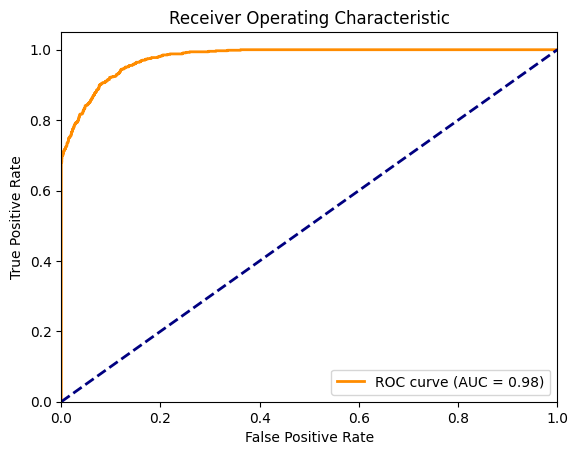

0.9776042730646409


In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Имея истинные метки классов и предсказанные вероятности класса "1":
y_pred_proba = clf.predict_proba(X_test)[:,1]

# Вычислить значения TPR и FPR для построения графика ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Вычислить AUC
auc_score = auc(fpr, tpr)

# Построение графика ROC
def plot_roc(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc(fpr, tpr)
print(auc_score)

In [12]:
from sklearn.metrics import classification_report

y_true_pred = clf.predict(X_test)

print(classification_report(y_test, y_true_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6699
           1       0.91      0.72      0.80       673

    accuracy                           0.97      7372
   macro avg       0.94      0.85      0.89      7372
weighted avg       0.97      0.97      0.97      7372



In [13]:
clf.fit(X_train, y_train)

y_true_pred = clf.predict(X)

print(classification_report(y, y_true_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     67168
           1       0.94      0.77      0.85      6550

    accuracy                           0.98     73718
   macro avg       0.96      0.88      0.92     73718
weighted avg       0.97      0.98      0.97     73718



Original data

In [14]:
X_res, y_res = sm.fit_resample(X, y)

clf.fit(X_res, y_res)
y_true_pred = clf.predict(X)

print(classification_report(y, y_true_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     67168
           1       0.94      0.78      0.86      6550

    accuracy                           0.98     73718
   macro avg       0.96      0.89      0.92     73718
weighted avg       0.98      0.98      0.98     73718



# Описание задания

Вам необходимо построить модель-классификатор по определению диабета. У вас нет никаких ограничений по инструментам, новым полям и способу энкодинга данных.

# О данных

Датасет представляет собой набор медицинских и демографических данных пациентов, а также их диагноз по диабету (положительный или отрицательный). 

Данные включают такие характеристики, как возраст, пол, индекс массы тела (BMI), гипертония, болезни сердца, история курения, уровень HbA1c и уровень глюкозы в крови. Этот набор данных можно использовать для создания моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации.

# Submission задания

Вам будет предоставлен второй датасет, без целевой переменной (таргет - diabetes)
Этот датасет необходимо будет проскорить и сабмитнуть в Google Classroom в формате .csv, с 2 стобцами: `ID` и `prediction`

Поле `prediction` должно быть предсказанием **<span style = 'color : green'> класса </span>** (`predict`), т.е. 1 или 0 а **<span style = 'color : red'>не вероятности </span>** (`predict_proba`)

In [20]:
df_test = pd.read_csv('/Users/dimmyt/Documents/PyCharmProjects/N--DS/N! weekly/weekly2/test_data - test_data.csv', index_col=0) 
IDS = df_test['ID']
df_test.drop('ID', inplace=True, axis=1)
df_test

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,60.0,1,0,former,23.77,4.8,130
1,Male,2.0,0,0,No Info,15.19,5.0,159
2,Female,74.0,0,0,not current,39.59,6.5,160
3,Female,51.0,0,0,never,26.67,6.6,80
4,Male,35.0,0,0,never,26.09,3.5,159
...,...,...,...,...,...,...,...,...
26141,Female,31.0,0,0,never,27.32,6.1,140
26142,Female,65.0,1,1,never,27.25,5.7,100
26143,Male,30.0,1,0,former,57.17,5.8,300
26144,Male,20.0,0,0,never,32.70,6.2,159


In [21]:
df_test.drop('smoking_history', inplace=True, axis=1)
df_test.drop('gender', inplace=True, axis=1)

In [22]:
df_test

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,60.0,1,0,23.77,4.8,130
1,2.0,0,0,15.19,5.0,159
2,74.0,0,0,39.59,6.5,160
3,51.0,0,0,26.67,6.6,80
4,35.0,0,0,26.09,3.5,159
...,...,...,...,...,...,...
26141,31.0,0,0,27.32,6.1,140
26142,65.0,1,1,27.25,5.7,100
26143,30.0,1,0,57.17,5.8,300
26144,20.0,0,0,32.70,6.2,159


In [23]:
y_pred_answer = clf.predict(df_test)